##### 1 - Fetch de data

In [4]:
import numpy as np
import requests,gzip,os,hashlib
%matplotlib inline

In [2]:
# fetch data

# Define a function that takes the utf-8 encoded data, decompress it and 
# convert it to a numpy array.
path='/home/juan/learning_python/data/'
def fetch(url):
    fp = os.path.join(path,hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp,"rb") as f:
            data = f.read()
    else:
        with open(fp,"wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

X = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

Since the data only contains a treining set and testing set, we need to split de training set into training and validation sets

In [5]:
# Validation split
rand = np.arange(60000)
np.random.shuffle(rand)
train_no = rand[:50000]

val_no = np.setdiff1d(rand,train_no)

X_train,X_val =X[train_no,:,:],X[val_no,:,:]
Y_train,Y_val =Y[train_no],Y[val_no]

The neural network is going to be a simple network of three layers. The input layer consist of  28*28 units which corresponds to every pixel in a 28 by 28 image from the dataset.
The second layer  drops down to 128 and the final layer with 10 units corresponding to digits 0 to 9

In [8]:
def init(x,y):
    layer = np.random.uniform(-1.,1.,size=(x,y))/np.sqrt(x*y)
    return layer.astype(np.float32)

np.random.seed(42)
l1 = init(28*28,128)
l2 = init(128,10)

In [11]:
# l1 is a matrix of size (28*28,128) or (784,128) and l2 is a matriz of size (128,10) or (128,10)
# We will use the sigmod function to transform the data

# Sigmod function

def sigmoid(x):
    return 1/(np.exp(-x)+1)

# derivative of sigmoid function

def d_sigmoid(x):
    return(np.exp(-x)/((np.exp(-x)+1)**2))

# The sigmoid function squishes the data to between 0 and 1

In [13]:
# Softmax function

# The softmax function is used to transform the output of the sigmoid function to a probability distribution


def softmax(x):
    exponents = np.exp(x)
    return exponents/np.sum(exponents)
    

In [14]:
# testing the softmax function

out = np.array([1,2,3])
softmax(out),sum(softmax(out))

(array([0.09003057, 0.24472847, 0.66524096]), 1.0)

In [15]:
# more testing

output_of_layer_2=np.array([12,34,-67,23,0,134,76,24,78,-98])
a=softmax(output_of_layer_2)
a,sum(a)

(array([1.03770332e-053, 3.72007598e-044, 5.09107081e-088, 6.21315959e-049,
        6.37586958e-059, 1.00000000e+000, 6.47023493e-026, 1.68891188e-048,
        4.78089288e-025, 1.75258947e-101]),
 1.0)

In [17]:
x = np.argmax(a)
x,output_of_layer_2[x]

(5, 134)

In [33]:
# If we use the softmax function we can get an overflow, so to prevent this
# we introduce a simplified version of the softmax function

# Simplified softmax function
# We refefine the softmax function as follows:


def softmax(x):
    exp_element = np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)

# derivative of simplified softmax function

def d_softmax(x):
    exp_element = np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

In [34]:
# Forward pass and backward pass

# The "forward pass" refers to calculation process, values of the output layers from the inputs data. It's traversing through all neurons from first to last layer.

#A loss function is calculated from the output values.

# And then "backward pass" refers to process of counting changes in weights (de facto learning), using gradient descent algorithm (or similar). Computation is made from last layer, backward to the first layer.

# Backward and forward pass makes together one "iteration"

In [35]:
def forward_backward_pass(x,y):
    targets = np.zeros((len(y),10), np.float32)
    targets[range(targets.shape[0]),y] = 1
 
    
    x_l1=x.dot(l1)
    x_sigmoid=sigmoid(x_l1)
    x_l2=x_sigmoid.dot(l2)
    out=softmax(x_l2)
   
 
    error=2*(out-targets)/out.shape[0]*d_softmax(x_l2)
    update_l2=x_sigmoid.T@error
    
    
    error=((l2).dot(error.T)).T*d_sigmoid(x_l1)
    update_l1=x.T@error

    return out,update_l1,update_l2 

In [38]:
# Training the network performing stochastic gradient descent

epochs=10000
lr=0.001
batch=128

losses,accuracies,val_accuracies=[],[],[]

for i in range(epochs):
    sample=np.random.randint(0,X_train.shape[0],size=(batch))
    x=X_train[sample].reshape((-1,28*28))
    y=Y_train[sample]
 

    out,update_l1,update_l2=forward_backward_pass(x,y)
  
    category=np.argmax(out,axis=1)
    accuracy=(category==y).mean()
    accuracies.append(accuracy)
    
    loss=((category-y)**2).mean()
    losses.append(loss.item())
    
    l1=l1-lr*update_l1
    l2=l2-lr*update_l2
    
    if(i%20==0):    
        X_val=X_val.reshape((-1,28*28))
        val_out=np.argmax(softmax(sigmoid(X_val.dot(l1)).dot(l2)),axis=1)
        val_acc=(val_out==Y_val).mean()
        val_accuracies.append(val_acc.item())
    if(i%500==0): print(f'For {i}th epoch: train accuracy: {accuracy:.3f} | validation accuracy:{val_acc:.3f}')

For 0th epoch: train accuracy: 0.117 | validation accuracy:0.069
For 500th epoch: train accuracy: 0.648 | validation accuracy:0.653
For 1000th epoch: train accuracy: 0.742 | validation accuracy:0.744
For 1500th epoch: train accuracy: 0.703 | validation accuracy:0.769
For 2000th epoch: train accuracy: 0.797 | validation accuracy:0.785
For 2500th epoch: train accuracy: 0.789 | validation accuracy:0.792
For 3000th epoch: train accuracy: 0.820 | validation accuracy:0.799
For 3500th epoch: train accuracy: 0.797 | validation accuracy:0.806
For 4000th epoch: train accuracy: 0.820 | validation accuracy:0.810
For 4500th epoch: train accuracy: 0.781 | validation accuracy:0.813
For 5000th epoch: train accuracy: 0.781 | validation accuracy:0.816
For 5500th epoch: train accuracy: 0.820 | validation accuracy:0.820
For 6000th epoch: train accuracy: 0.844 | validation accuracy:0.822
For 6500th epoch: train accuracy: 0.820 | validation accuracy:0.822
For 7000th epoch: train accuracy: 0.812 | validation

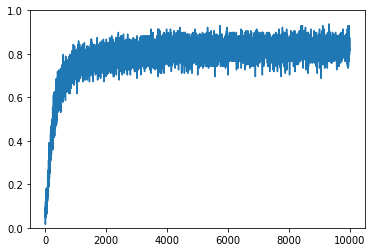

In [39]:
# done, let's plot the results

plt.ylim(-0,1,1.1)
plot(accuracies)

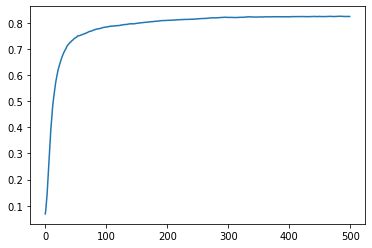

In [40]:
plot(val_accuracies)

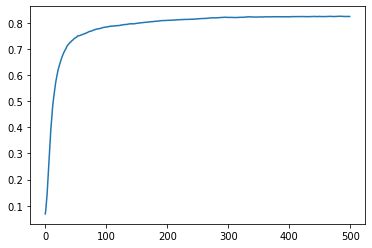

In [41]:
# Testing the model

plot(val_accuracies)

array([7])

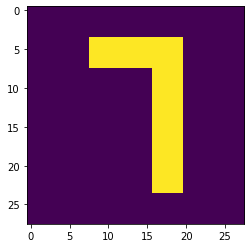

In [42]:
# this should look like a 7


m = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,0,0,0]]

m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
m=m.reshape(1,-1)
imshow(m.reshape(28,28))
x = np.argmax(sigmoid(m.dot(l1)).dot(l2),axis=1)
x


array([1])

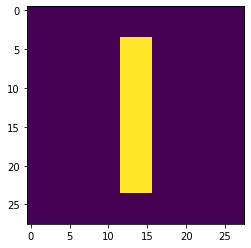

In [43]:
n = [[0,0,0,0,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,0,0,0,0]]

n = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n])
n=n.reshape(1,-1)
imshow(n.reshape(28,28))
x = np.argmax(sigmoid(n.dot(l1)).dot(l2),axis=1)
x